# 1. Introduction

Achmad Dhani

Dataset: [Water Quality](https://www.kaggle.com/datasets/adityakadiwal/water-potability)

Objective: Water is essential for all forms of life, yet its quality can vary dramatically, with the potential to sustain health or cause disease. The distinction between potable water, which is safe for consumption, and non-potable water, which poses health risks, determined by the presence of certain chemicals. By employing classification model focused on the Recall metric, we can effectively predict the potability of water, ensuring its safety for consumption.

# 2. Importing Libraries

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
# libraries for preprocessing
from sklearn.impute import KNNImputer
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
#models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# others
import time
from joblib import dump

# 3. Data loading

In [2]:
# reading the file
df= pd.read_csv('water_potability.csv')
df.head(10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


In [3]:
# summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [4]:
# check for missing values
missing = df.isna().sum()
total_missing_values = missing.sum()


# if function for missing values
if total_missing_values > 0:
    columns_with_missing_values = missing[missing > 0] # the index represents the names of the columns
    missing_percentage = (columns_with_missing_values / df.shape[0]) * 100
    
    print('Total missing values in the dataset:', total_missing_values) # total
    print('Columns with missing values:', columns_with_missing_values.index.tolist())
    print('')
    print('Number of missing values per column:')
    print(columns_with_missing_values)
    print('')
    print('Missing data percentage (%):')
    print(missing_percentage)
else:
    print('No missing values found.')

Total missing values in the dataset: 1434
Columns with missing values: ['ph', 'Sulfate', 'Trihalomethanes']

Number of missing values per column:
ph                 491
Sulfate            781
Trihalomethanes    162
dtype: int64

Missing data percentage (%):
ph                 14.987790
Sulfate            23.840049
Trihalomethanes     4.945055
dtype: float64


In [3]:
# checking duplicate values
duplicates= df.duplicated().sum()

print(f"Data has {duplicates} duplicated values")

Data has 0 duplicated values


In [4]:
# renaming columns to all lowercase
df.columns = [col.lower() for col in df.columns]

- The data consist of `3276 entries` with `10 columns` which consist `9 float` and `1 interger`.
- The dataset has a total of `1434` missing values.
- These missing values are in `'ph', 'sulfate', 'trihalomethanes'`
	- 'ph' has `491` missing values (`15%`)
	- 'sulfate' has `781` missing values (`24%`)
	- 'trihalomethanes' has `162` missing values (`5%`)

# 4. EDA

## About the Dataset

1. pH value:
PH is an important parameter in evaluating the acid–base balance of water. It is also the indicator of acidic or alkaline condition of water status. WHO has recommended maximum permissible limit of pH from 6.5 to 8.5. The current investigation ranges were 6.52–6.83 which are in the range of WHO standards.

2. Hardness:
Hardness is mainly caused by calcium and magnesium salts. These salts are dissolved from geologic deposits through which water travels. The length of time water is in contact with hardness producing material helps determine how much hardness there is in raw water. Hardness was originally defined as the capacity of water to precipitate soap caused by Calcium and Magnesium.

3. Solids (Total dissolved solids - TDS):
Water has the ability to dissolve a wide range of inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates etc. These minerals produced un-wanted taste and diluted color in appearance of water. This is the important parameter for the use of water. The water with high TDS value indicates that water is highly mineralized. Desirable limit for TDS is 500 mg/l and maximum limit is 1000 mg/l which prescribed for drinking purpose.

4. Chloramines:
Chlorine and chloramine are the major disinfectants used in public water systems. Chloramines are most commonly formed when ammonia is added to chlorine to treat drinking water. Chlorine levels up to 4 milligrams per liter (mg/L or 4 parts per million (ppm)) are considered safe in drinking water.

5. Sulfate:
Sulfates are naturally occurring substances that are found in minerals, soil, and rocks. They are present in ambient air, groundwater, plants, and food. The principal commercial use of sulfate is in the chemical industry. Sulfate concentration in seawater is about 2,700 milligrams per liter (mg/L). It ranges from 3 to 30 mg/L in most freshwater supplies, although much higher concentrations (1000 mg/L) are found in some geographic locations.

6. Conductivity:
Pure water is not a good conductor of electric current rather’s a good insulator. Increase in ions concentration enhances the electrical conductivity of water. Generally, the amount of dissolved solids in water determines the electrical conductivity. Electrical conductivity (EC) actually measures the ionic process of a solution that enables it to transmit current. According to WHO standards, EC value should not exceeded 400 μS/cm.

7. Organic_carbon:
Total Organic Carbon (TOC) in source waters comes from decaying natural organic matter (NOM) as well as synthetic sources. TOC is a measure of the total amount of carbon in organic compounds in pure water. According to US EPA < 2 mg/L as TOC in treated / drinking water, and < 4 mg/Lit in source water which is use for treatment.

8. Trihalomethanes:
THMs are chemicals which may be found in water treated with chlorine. The concentration of THMs in drinking water varies according to the level of organic material in the water, the amount of chlorine required to treat the water, and the temperature of the water that is being treated. THM levels up to 80 ppm is considered safe in drinking water.

9. Turbidity:
The turbidity of water depends on the quantity of solid matter present in the suspended state. It is a measure of light emitting properties of water and the test is used to indicate the quality of waste discharge with respect to colloidal matter. The mean turbidity value obtained for Wondo Genet Campus (0.98 NTU) is lower than the WHO recommended value of 5.00 NTU.

10. Potability:
Indicates if water is safe for human consumption where 1 means Potable and 0 means Not potable.

## Understanding Data

In [7]:
# summary of the data entries
df.describe()

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [8]:
# displaying the skewness
list_skew = []
df_without_objects = df.select_dtypes(exclude=['object'])
for columns in df_without_objects.columns:
    if df_without_objects[columns].skew() <= -0.5 or df_without_objects[columns].skew() >= 0.5:  
        list_skew.append(columns)
        print(f"{columns} has skewness of: {df_without_objects[columns].skew():.2f}")
    else:
        print(f"{columns} not skewed")

ph not skewed
hardness not skewed
solids has skewness of: 0.62
chloramines not skewed
sulfate not skewed
conductivity not skewed
organic_carbon not skewed
trihalomethanes not skewed
turbidity not skewed
potability not skewed


- Most of the data has good distribution, only `solids` has `0,62` skewness

## What are the correlation between all the variables?

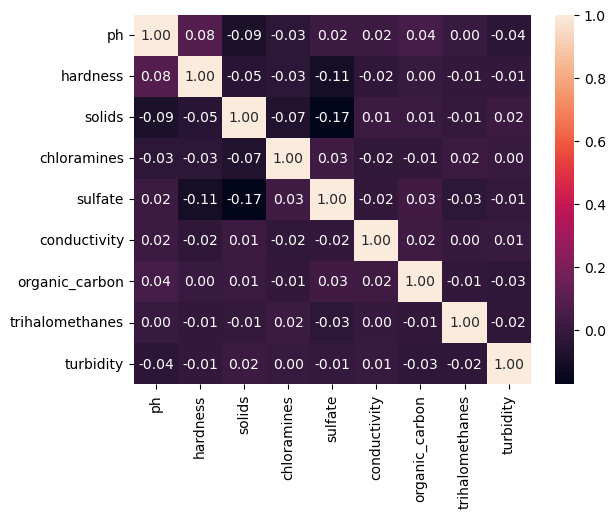

In [9]:
# correlation variables wiht pearsons
water_signal = df.iloc[:, 0:9] 
correlation_matrix = water_signal.corr(method='pearson')
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='rocket')
plt.show()

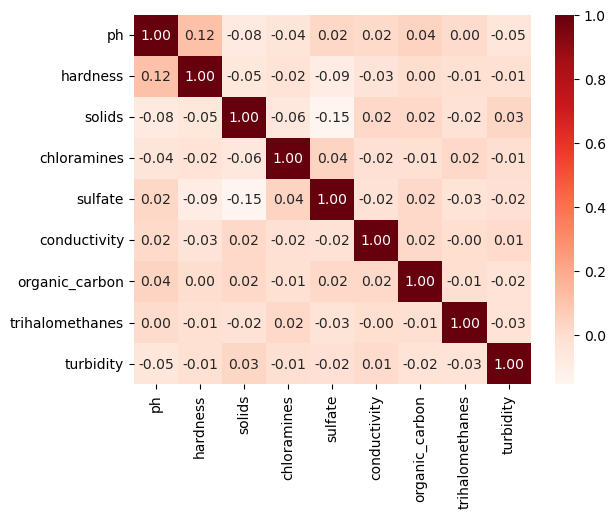

In [10]:
# correlation variables with spearman
correlation_matrix = water_signal.corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Reds')
plt.show()

Based on both visualization, most of the variables do not have any relationship except for a few.

- `Hardness` has a very positive low value with `ph` in spearman but close to 0 in pearsons. This suggests there might be a very weak positive non-linear relationship.
- `Sulfate` with `Solids` and with `Sulfate` has a very low negative value both in spearman and pearsons. This suggests there might be a very weak negative linear relationship.

## What is the distribution of pH values across the sampled water?

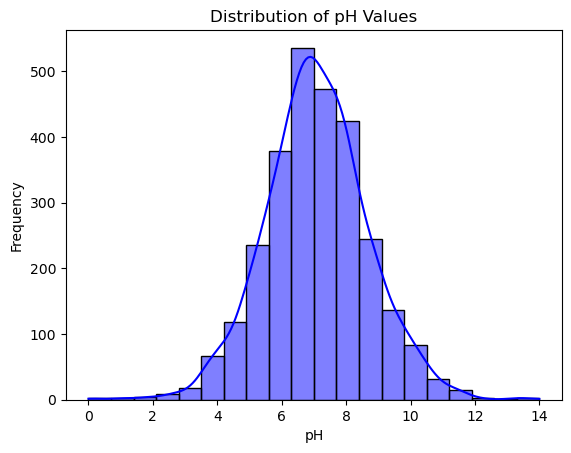

In [11]:
# visualization
sns.histplot(df['ph'], kde=True, bins=20, color='blue')
plt.title('Distribution of pH Values')
plt.xlabel('pH')
plt.ylabel('Frequency')
plt.show()

- The water sample taken mostly has ph between `5-9`
- The visualization also suggest a lot of data are in the range for drinkable water but doesn't mean that the water is drinkable.
- This could mean most water samples that's taken could come contaminated water bodies

## Does hardness correlate with any other water quality parameters like ph and sulfate?


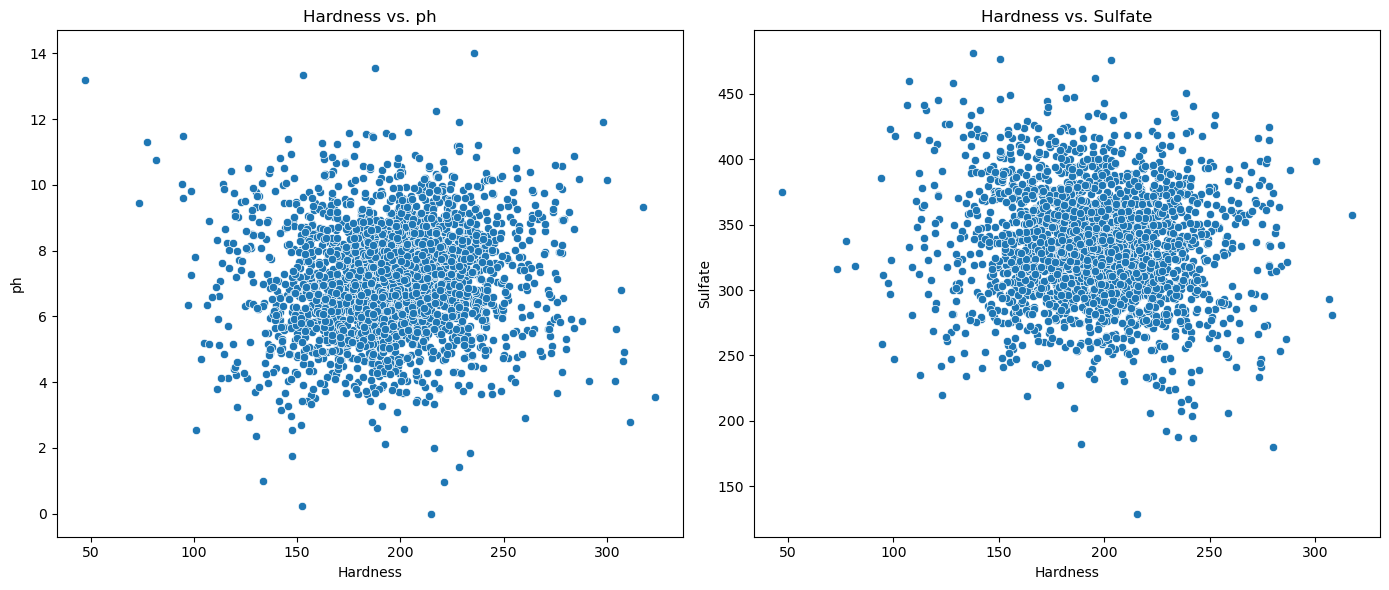

In [59]:
# subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# hardness vs solids
sns.scatterplot(x='hardness', y='ph', data=df, ax=ax1)
ax1.set_title('Hardness vs. ph')
ax1.set_xlabel('Hardness')
ax1.set_ylabel('ph')

# hardness vs conductivity
sns.scatterplot(x='hardness', y='sulfate', data=df, ax=ax2)
ax2.set_title('Hardness vs. Sulfate')
ax2.set_xlabel('Hardness')
ax2.set_ylabel('Sulfate')

plt.tight_layout()
plt.show()

- The scatterplot visualization suggests there are no relationship.
- This suggests water contamination comes from a variety of different variables 

## What is the correlation between total dissolved solids and sulfate in the water samples?

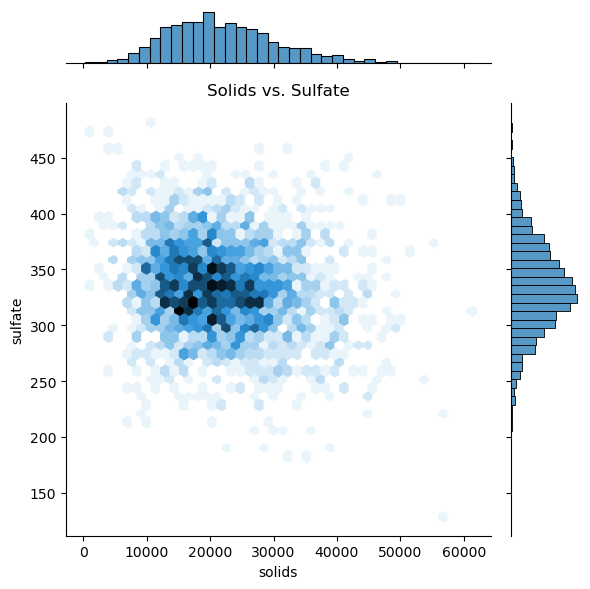

In [60]:
# visualizaition
sns.jointplot(x='solids', y='sulfate', data=df, kind='hex')
plt.title('Solids vs. Sulfate')
plt.tight_layout()
plt.show()

- The visualization above shows the highest concentration of points are in the range of `15,000 to 30,000` solids and `300 to 350` sulfate levels. The color intensity becomes darker as the concentration of point within the hexagons increases. This suggests the most common values for both solids and sulfate in the dataset are in these range.
- There seems to be no clear linear relationship and no distinctive trend between the two.
- This suggests amount of solids doesn't effects the amount of sulfate levels

## How do chloramine concentrations compare with disinfection byproducts like THMs?

In [220]:
# grouping
mean_concentrations = df.groupby('potability')[['chloramines', 'trihalomethanes']].mean().reset_index()
print(mean_concentrations)

   potability  chloramines  trihalomethanes
0           0     7.092175        66.303555
1           1     7.169338        66.539684


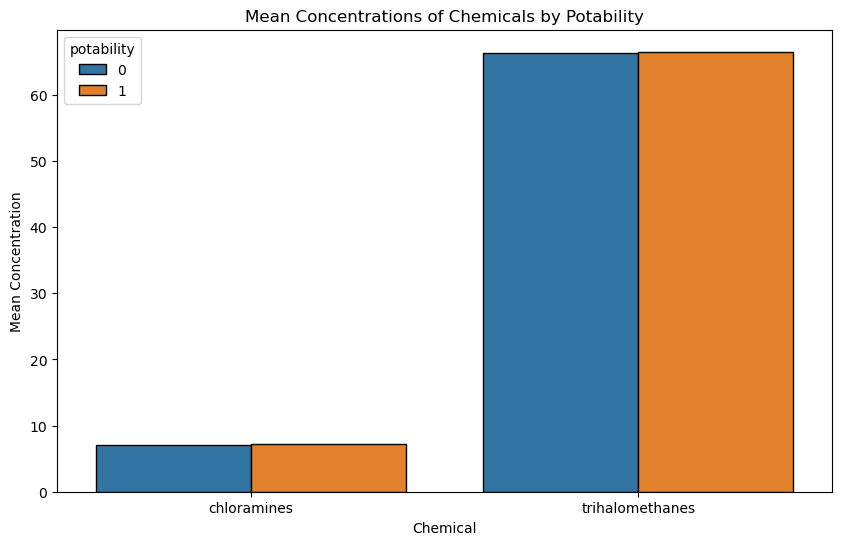

In [222]:
# better name
mean_concentrations_melted = mean_concentrations.melt(id_vars='potability', 
                                                            var_name='Chemical', 
                                                            value_name='Concentration')

# visualziation
plt.figure(figsize=(10, 6))
sns.barplot(x='Chemical', y='Concentration', hue='potability', data=mean_concentrations_melted, edgecolor='black')

plt.title('Mean Concentrations of Chemicals by Potability')
plt.xlabel('Chemical')
plt.ylabel('Mean Concentration')

plt.show()

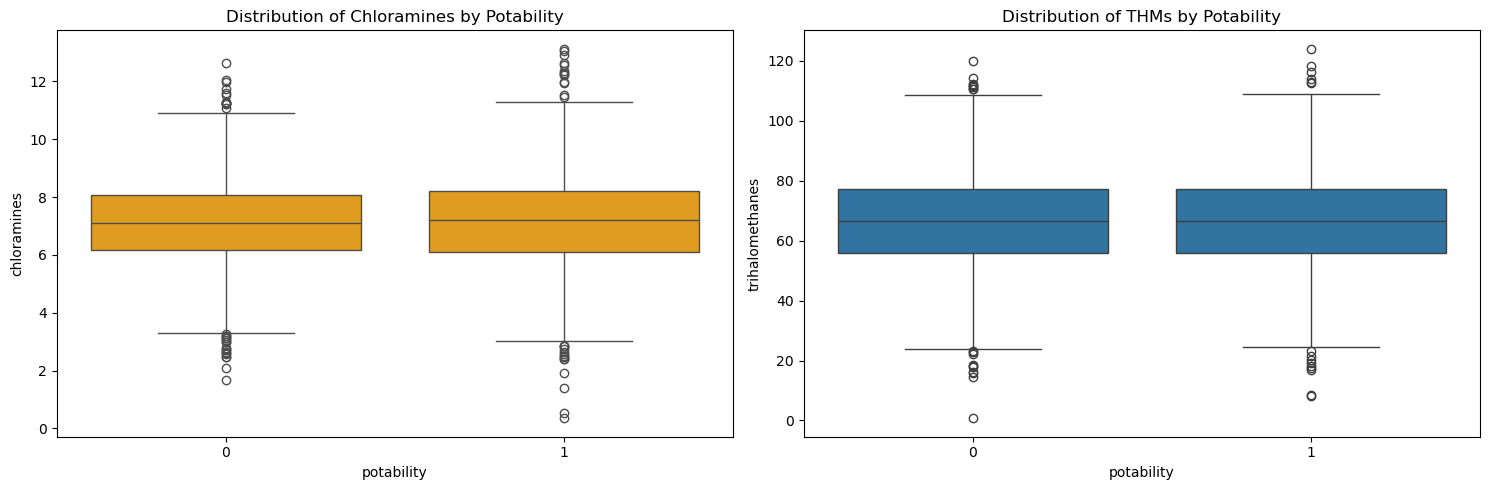

In [219]:
# boxplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='potability', y='chloramines', data=df, ax=axes[0], color='orange')
axes[0].set_title('Distribution of Chloramines by Potability')

sns.boxplot(x='potability', y='trihalomethanes', data=df, ax=axes[1])
axes[1].set_title('Distribution of THMs by Potability')

plt.tight_layout()
plt.show()

- The visualization above show's the concentration of chemicals within drinkable water.
- Both chemical has roughly the same average between drinkable and not, this suggest there might be a range to determine whether the water is potable.
- The distribution visualization for cholarimines, there seem to be more variant of outliers compared to the non-potable water which has more dense outliers.
- THM's distribution also shows the same thing where there seem to be a more variant outliers than non-potable water

## How do sulfate levels in drinking water compare to those that's not?

In [224]:
# grouping
pota_sulf = df.groupby('potability')['sulfate'].mean()
print(pota_sulf)

potability
0    334.56429
1    332.56699
Name: sulfate, dtype: float64


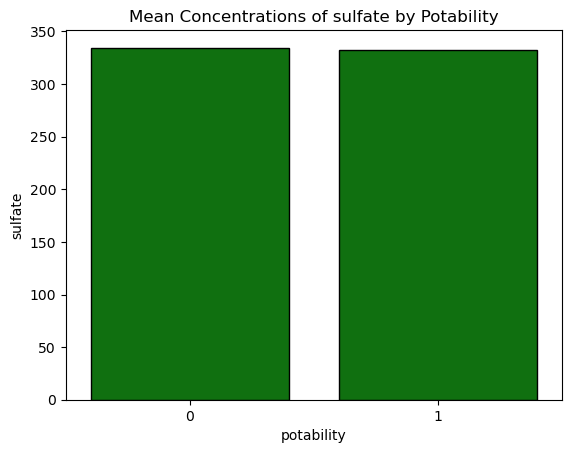

In [225]:
# visualization
sns.barplot(data=pota_sulf, edgecolor='black', color='green')
plt.title('Mean Concentrations of sulfate by Potability')
plt.show()

- The average concentration of sulfate between potable water and not is relatively the same with non-potable water has a little higher average by `0,2`

## Understanding Missing Values

**From Data Loading**

Total missing values in the dataset: 1434

Columns with missing values: `['ph', 'Sulfate', 'Trihalomethanes']`

Number of missing values per column:
>ph                 491
>
>Sulfate            781
>
>Trihalomethanes    162
>
>dtype: int64

Missing data percentage (%):
>ph                 14.987790
>
>Sulfate            23.840049
>
>Trihalomethanes     4.945055

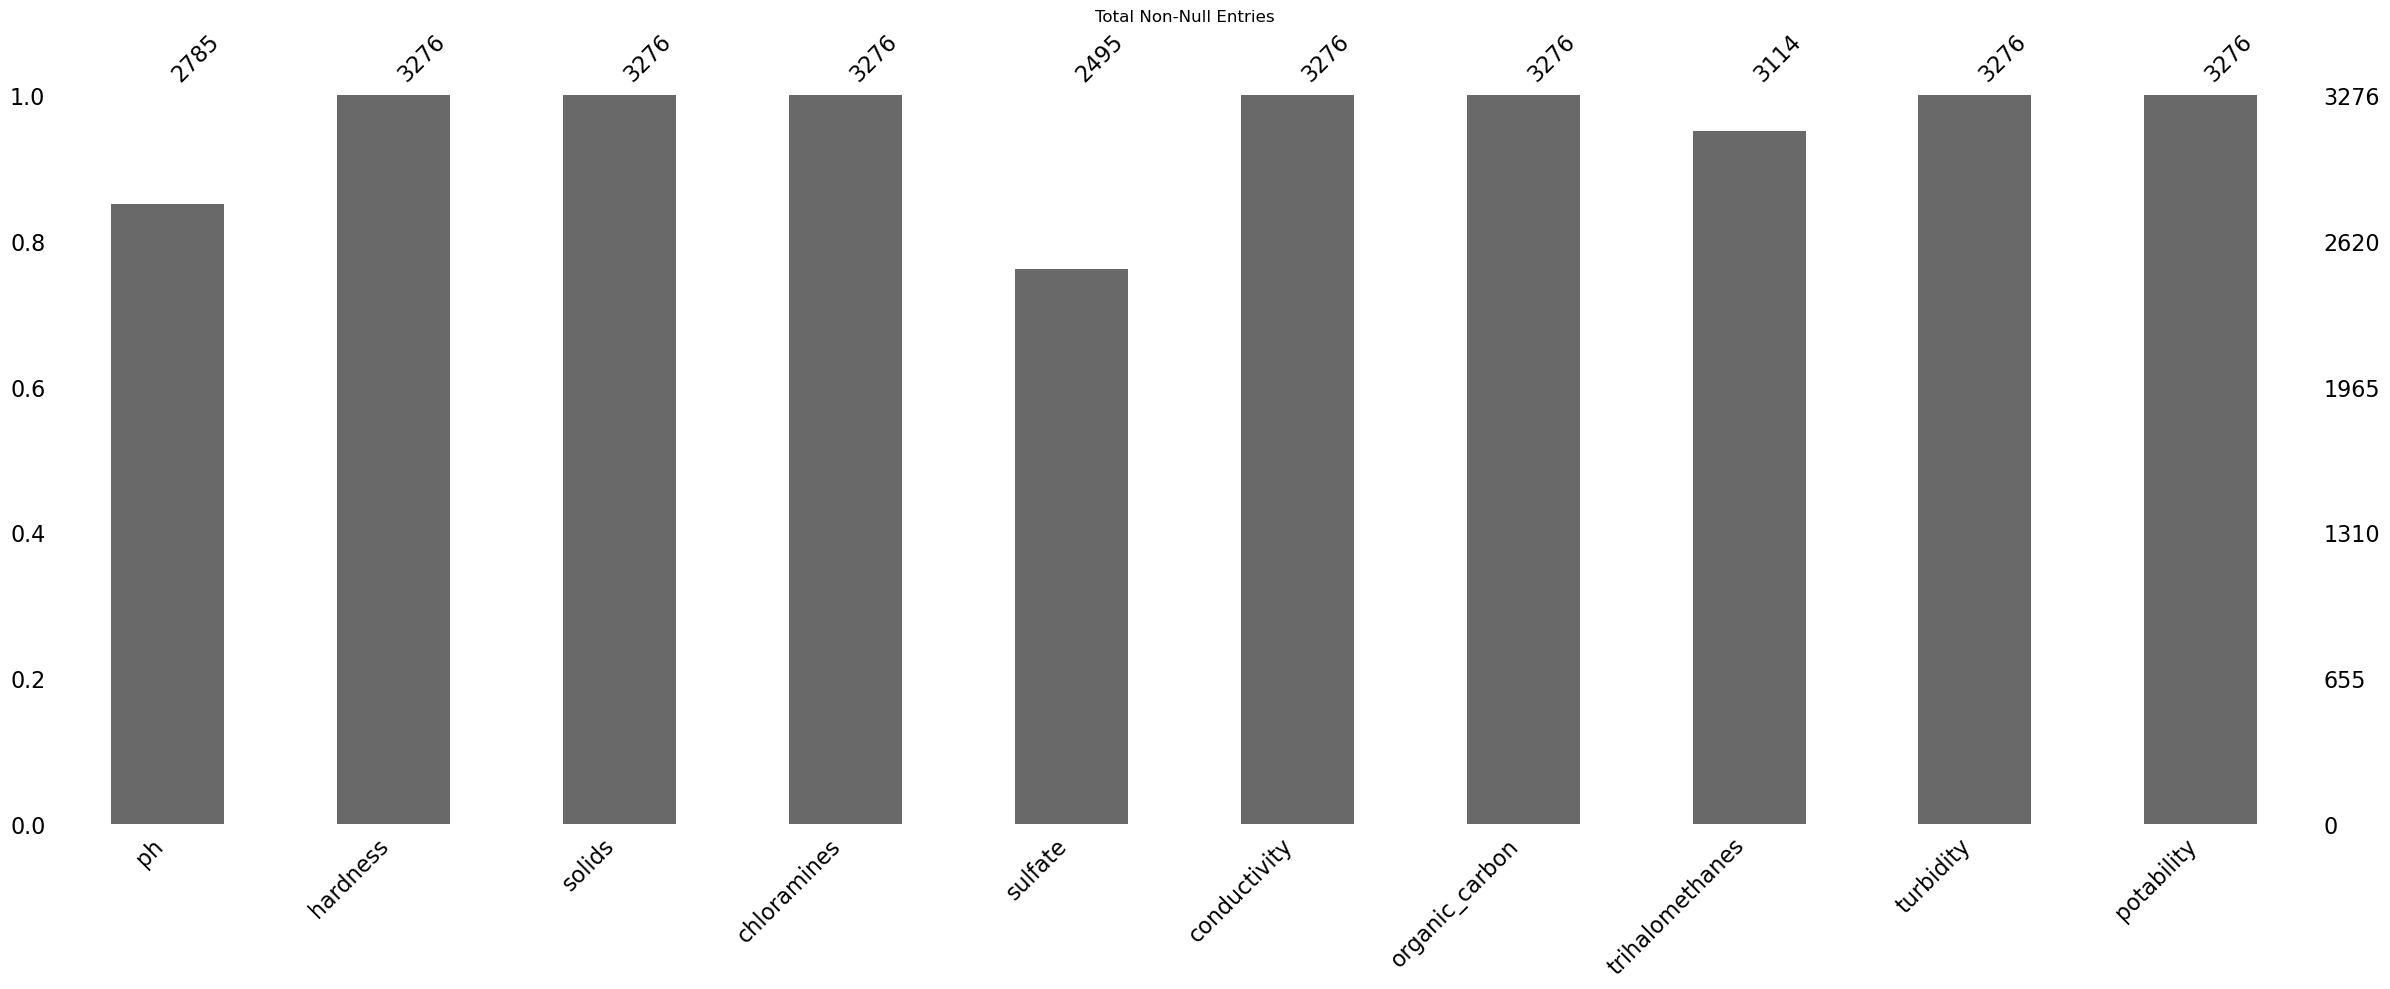

In [134]:
# visualization of missing values with missingno
plt.figure(figsize=(10, 8))
msno.bar(df)
plt.title('Total Non-Null Entries')
plt.tight_layout()
plt.show()

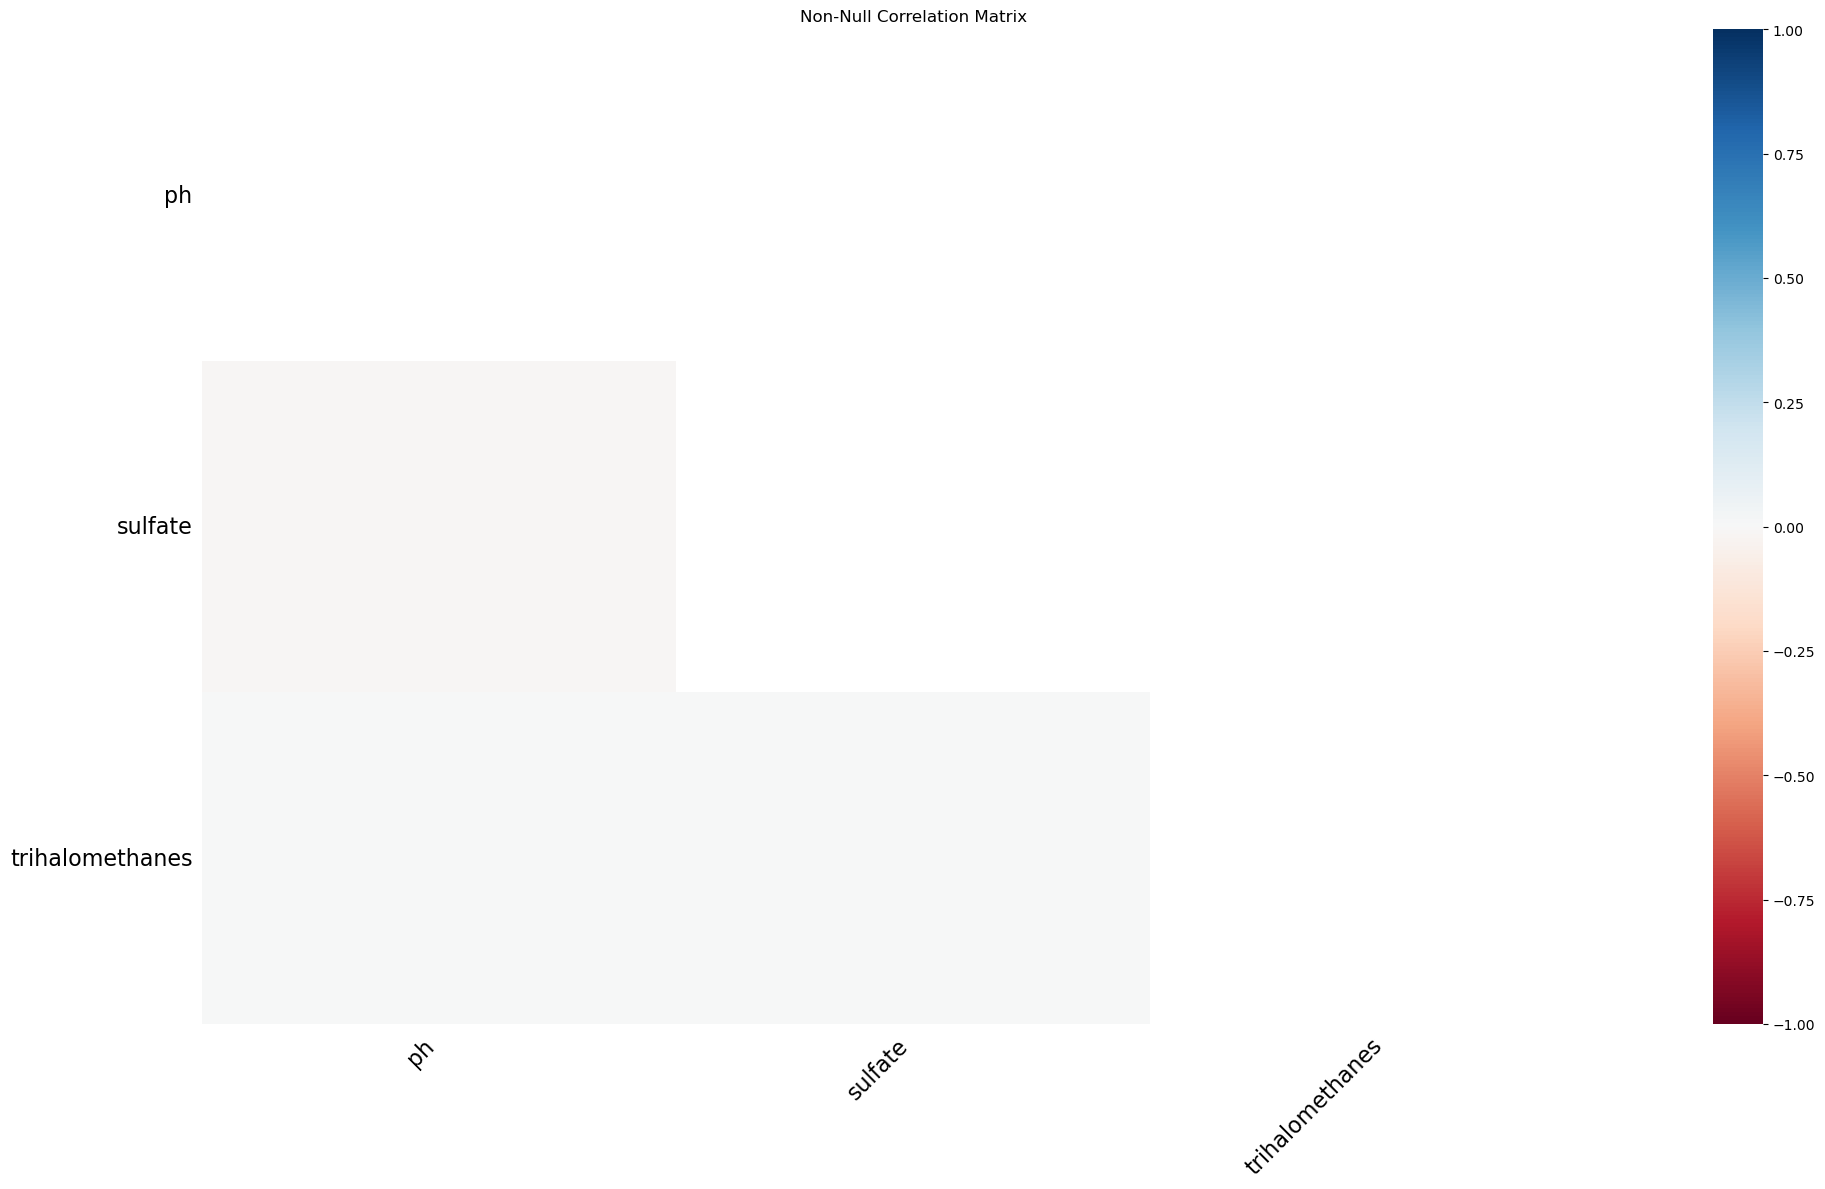

In [244]:
# heatmap of correlation between missing values
msno.heatmap(df)
plt.title('Non-Null Correlation Matrix')
plt.tight_layout()
plt.show()

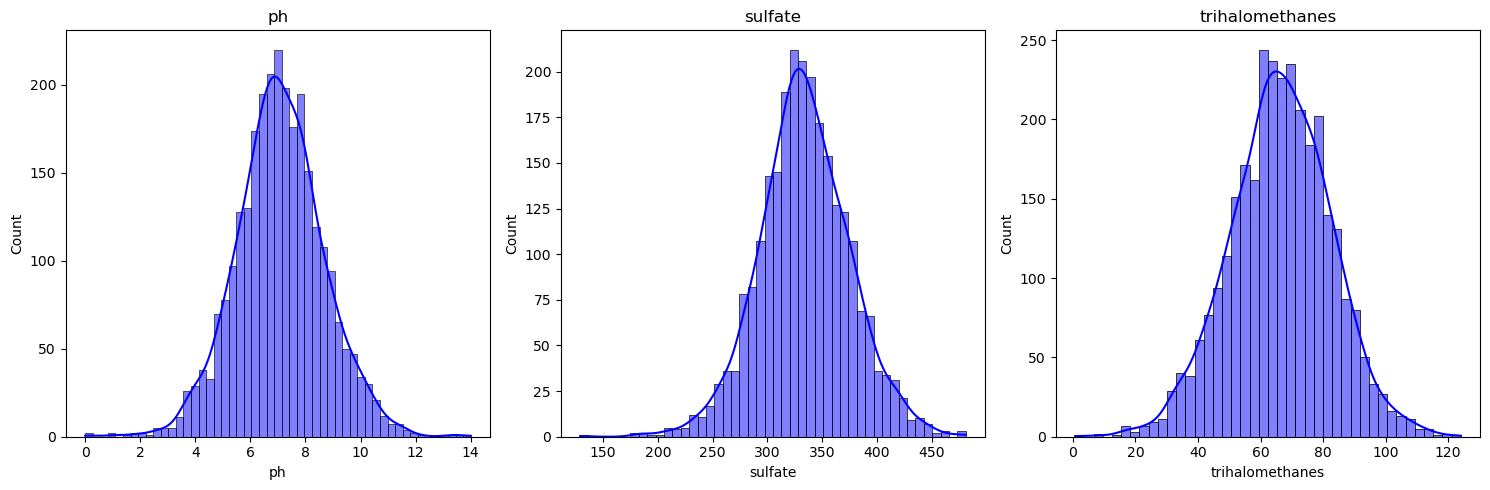

In [140]:
# visualization
missing_columns=['ph', 'sulfate', 'trihalomethanes']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes = axes.ravel()
for index, miss in enumerate(missing_columns):
    sns.histplot(df[miss], kde=True, color='blue', ax=axes[index])
    axes[index].set_title(miss)

plt.tight_layout()
plt.show()

- Based on the visualization above, the missing values have no correlation and can be cosidered `missingness is completly random`
- Despite having missing values, the data distribution is good
- The missing values being random could be due to the person that took the water sample did not have the equipment to measure the chemical level hence it's missing.
- The missing values takes a lot prom the dataset with ph having `15%` mmissing values, sulfate has `24%` and THM's has `5%`. These missing values will be imputed

# 5. Feature Engineering

## Feature Selection

All the feature will be selected since all the chemicals are in the water itself and has it's own properties

## Handling Missing Values

In [12]:
df1= df.copy()

In [13]:
def null_imputer(column):
    '''
    This function is for automating KNN Imputer
    '''
    imputer = KNNImputer(n_neighbors=5)
    df1[column] = imputer.fit_transform(df1[[column]])
    print(f"{column} has {df1[column].isnull().sum()} missing values")
    return df1[column].describe()

In [14]:
# imputing with KNN
list= ['ph', 'sulfate', 'trihalomethanes']
for col in list:
    null_imputer(col)

ph has 0 missing values
sulfate has 0 missing values
trihalomethanes has 0 missing values


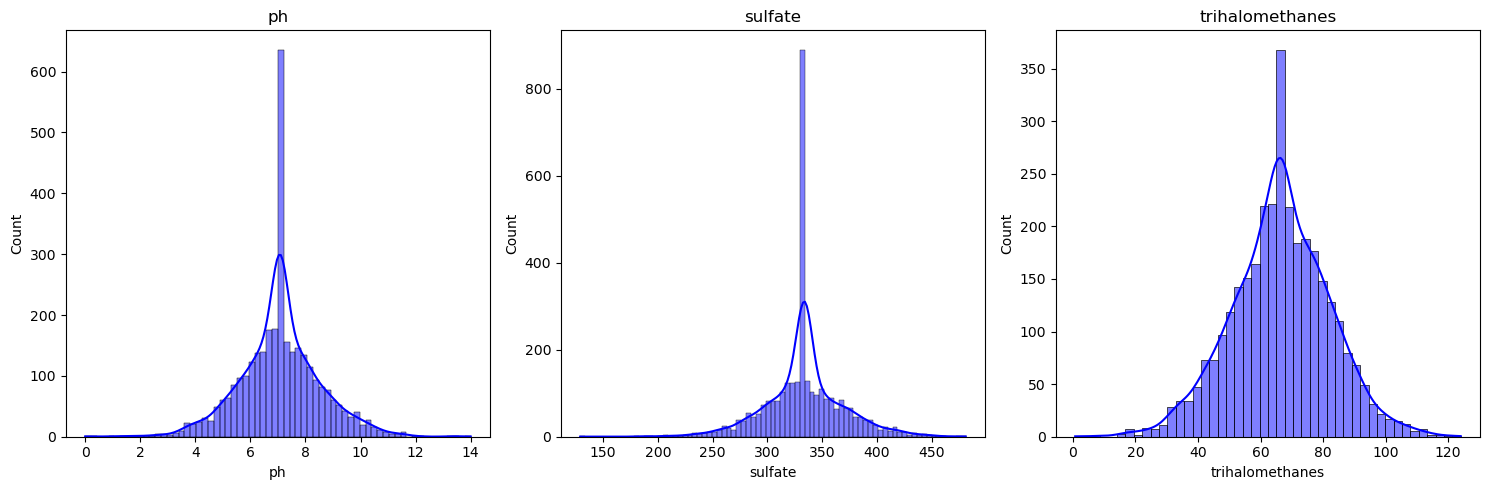

In [15]:
# visualization
missing_columns=['ph', 'sulfate', 'trihalomethanes']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes = axes.ravel()
for index, miss in enumerate(missing_columns):
    sns.histplot(df1[miss], kde=True, color='blue', ax=axes[index])
    axes[index].set_title(miss)

plt.tight_layout()
plt.show()

In [5]:
df2= df.copy()

In [6]:
# random imputing
missing_values = df2.columns[df2.isna().any()].tolist()

for var in missing_values:

    random_sample_df = df2[var].dropna().sample(df2[var].isnull().sum(),
                                                  random_state=0)
    random_sample_df.index = df2[df2[var].isnull()].index

    df2.loc[df2[var].isnull(), var] = random_sample_df

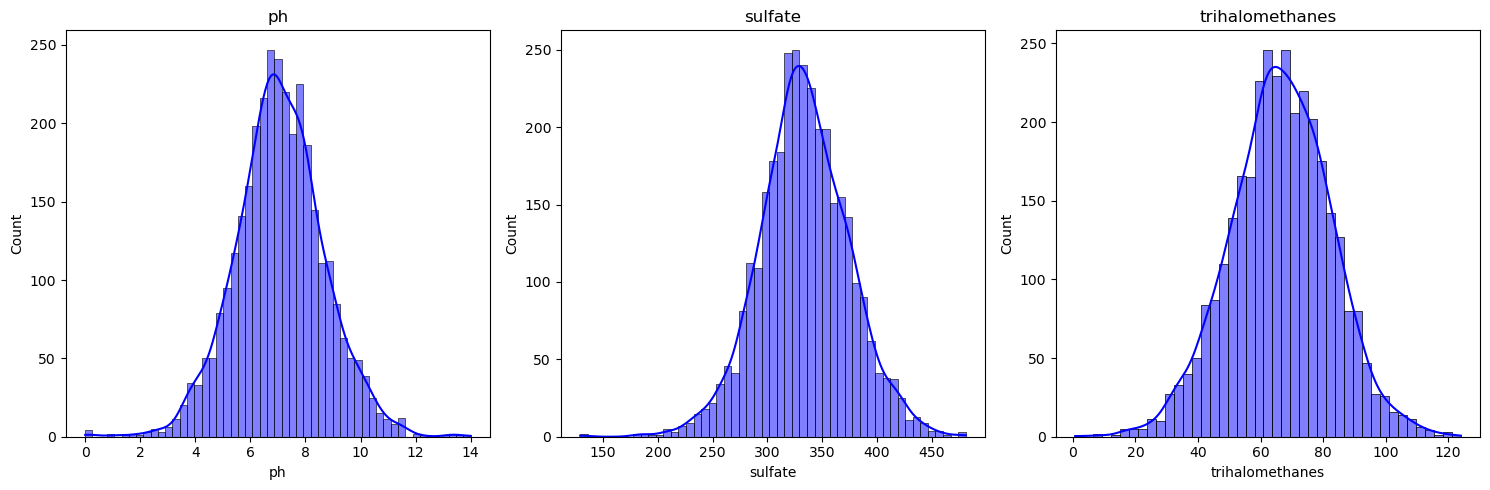

In [18]:
# visualization
missing_columns=['ph', 'sulfate', 'trihalomethanes']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes = axes.ravel()
for index, miss in enumerate(missing_columns):
    sns.histplot(df2[miss], kde=True, color='blue', ax=axes[index])
    axes[index].set_title(miss)

plt.tight_layout()
plt.show()

In [7]:
# checkpoint
clean= df2.copy()

- The missing values are imputed with random sampling since the distribution after imputing is much better than KNN imputer.
- From what KNN imputer distribution, the missing values seems to be median's

## Feature Splitting

In [8]:
# splitting the predictors and response
X = clean.drop('potability', axis=1)
y = clean['potability']
X

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity
0,9.074923,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135
1,3.716080,129.422921,18630.057858,6.635246,298.082462,592.885359,15.180013,56.329076,4.500656
2,8.099124,224.236259,19909.541732,9.275884,367.224297,418.606213,16.868637,66.420093,3.055934
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075
...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821
3272,7.808856,193.553212,17329.802160,8.061362,331.338739,392.449580,19.903225,96.442129,2.798243
3273,9.419510,175.762646,33155.578218,7.350233,341.256362,432.044783,11.039070,69.845400,3.298875
3274,5.126763,230.603758,11983.869376,6.303357,334.619524,402.883113,11.168946,77.488213,4.708658


In [90]:
# checking class balance
print(y.value_counts(normalize=True))

potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64


In [9]:
# splitting between train and test with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46, stratify=y)

print('X-train', X_train.shape)
print('X-Test', X_test.shape)

X-train (2620, 9)
X-Test (656, 9)


## Handling Outliers

In [10]:
# capping outliers
winsoriser_fare = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=1.5,
                             variables=X_train.columns.to_list())

X_train_capped = winsoriser_fare.fit_transform(X_train)
X_test_capped = winsoriser_fare.transform(X_test)

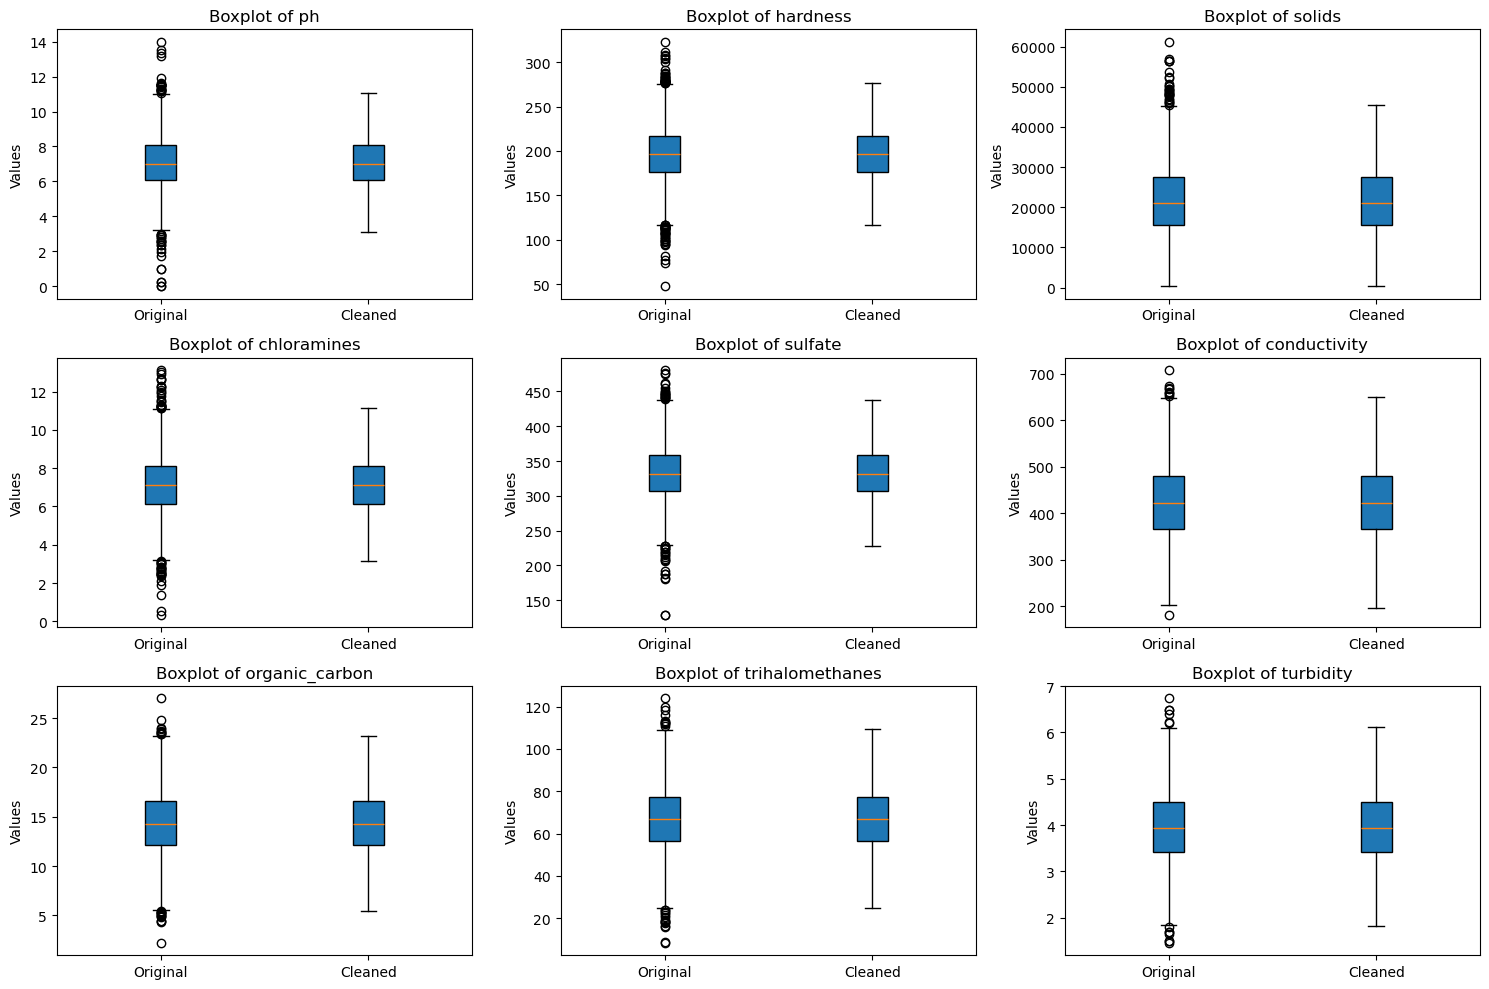

In [93]:
# boxplot after and before removing outliers
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()
columns = X_train.columns.to_list()

for i, col in enumerate(columns):
    axes[i].boxplot(X_train[col], positions=[1], patch_artist=True)
    axes[i].boxplot(X_train_capped[col], positions=[2], patch_artist=True)
    
    axes[i].set_title('Boxplot of ' + col)
    axes[i].set_xticks([1, 2])
    axes[i].set_xticklabels(['Original', 'Cleaned'])
    axes[i].set_ylabel('Values')

plt.tight_layout()
plt.show()

- Outliers is capped because it's considered natural outliers.
- Based on the visualization there are difference between the original and cleaned one without the outliers
- These outliers is handled because the models used are sensitive to outliers

## PCA

In [94]:
# for pca
scaler= StandardScaler()
X_train_scaled= scaler.fit_transform(X_train_capped)

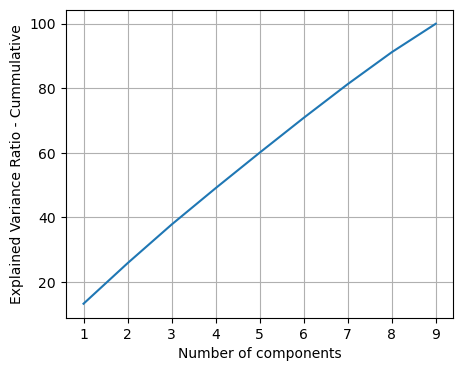

In [95]:
# pca
pca = PCA()
pca.fit(X_train_scaled)

# visual
plt.figure(figsize=[5, 4])
plt.plot(range(1, len(X.columns) + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')
plt.grid()
plt.show()

- Based on the visualization of PCA, there is a linear relationship between number of components and the EVR cummulative
- This suggest, each feature is important and retains unique information of the dataset

# 6. Defining Model

In [11]:
# scaling
columns_to_scale = clean.columns[clean.columns != 'potability'].to_list()
preprocessor = make_column_transformer((StandardScaler(), columns_to_scale), remainder='passthrough')

In [13]:
# Random Forest
forest_pipe = make_pipeline_imb(
    preprocessor,
    SMOTE(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)
# SVC pipeline
svc_pipe = make_pipeline_imb(
    preprocessor,
    SMOTE(random_state=42),
    SVC()
)

# KNN
knn_pipe = make_pipeline_imb(
    preprocessor,
    SMOTE(random_state=42),
    KNeighborsClassifier(n_jobs=-1)
)
# tree
tree_pipe = make_pipeline_imb(
    preprocessor,
    SMOTE(random_state=42),
    DecisionTreeClassifier()
)

# adaBoost Pipe
ada_pipe = make_pipeline_imb(
    preprocessor,
    SMOTE(random_state=42),
    AdaBoostClassifier(random_state=42)
)

# 7. Training Model

In [16]:
# forest
forest_pipe.fit(X_train_capped, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['ph', 'hardness', 'solids',
                                                   'chloramines', 'sulfate',
                                                   'conductivity',
                                                   'organic_carbon',
                                                   'trihalomethanes',
                                                   'turbidity'])])),
                ('smote', SMOTE(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

In [17]:
# svc
svc_pipe.fit(X_train_capped, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['ph', 'hardness', 'solids',
                                                   'chloramines', 'sulfate',
                                                   'conductivity',
                                                   'organic_carbon',
                                                   'trihalomethanes',
                                                   'turbidity'])])),
                ('smote', SMOTE(random_state=42)), ('svc', SVC())])

In [18]:
# knn
knn_pipe.fit(X_train_capped, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['ph', 'hardness', 'solids',
                                                   'chloramines', 'sulfate',
                                                   'conductivity',
                                                   'organic_carbon',
                                                   'trihalomethanes',
                                                   'turbidity'])])),
                ('smote', SMOTE(random_state=42)),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

In [19]:
# tree
tree_pipe.fit(X_train_capped, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['ph', 'hardness', 'solids',
                                                   'chloramines', 'sulfate',
                                                   'conductivity',
                                                   'organic_carbon',
                                                   'trihalomethanes',
                                                   'turbidity'])])),
                ('smote', SMOTE(random_state=42)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [14]:
# adaboost
ada_pipe.fit(X_train_capped, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['ph', 'hardness', 'solids',
                                                   'chloramines', 'sulfate',
                                                   'conductivity',
                                                   'organic_carbon',
                                                   'trihalomethanes',
                                                   'turbidity'])])),
                ('smote', SMOTE(random_state=42)),
                ('adaboostclassifier', AdaBoostClassifier(random_state=42))])

# 8. Model Evaluation

## Base Model

In [12]:
def performance_check(clf, X, y):
    '''
    This function is use to display the confusion matrix of the model
    and print classification report.
    '''
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print(classification_report(y, y_pred, zero_division=0))

Random Forest Train


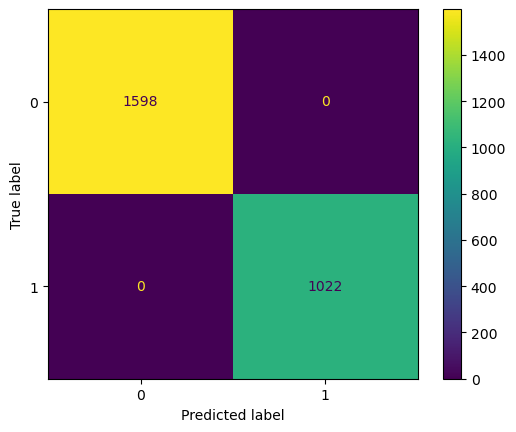

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1598
           1       1.00      1.00      1.00      1022

    accuracy                           1.00      2620
   macro avg       1.00      1.00      1.00      2620
weighted avg       1.00      1.00      1.00      2620


Random Forest Test


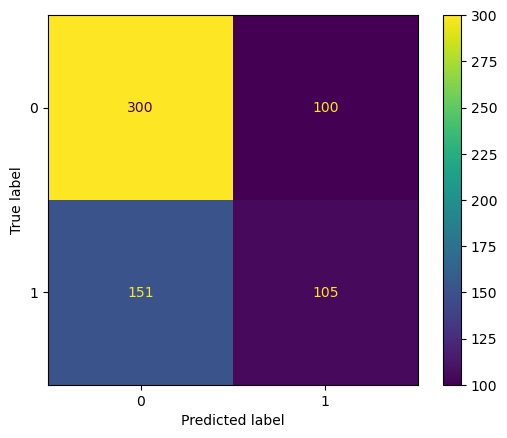

              precision    recall  f1-score   support

           0       0.67      0.75      0.71       400
           1       0.51      0.41      0.46       256

    accuracy                           0.62       656
   macro avg       0.59      0.58      0.58       656
weighted avg       0.61      0.62      0.61       656



In [155]:
# calling function for Random Forest
print('Random Forest Train')
performance_check(forest_pipe, X_train_capped, y_train)
print('')

print('Random Forest Test')
performance_check(forest_pipe, X_test_capped, y_test)

SVC Train


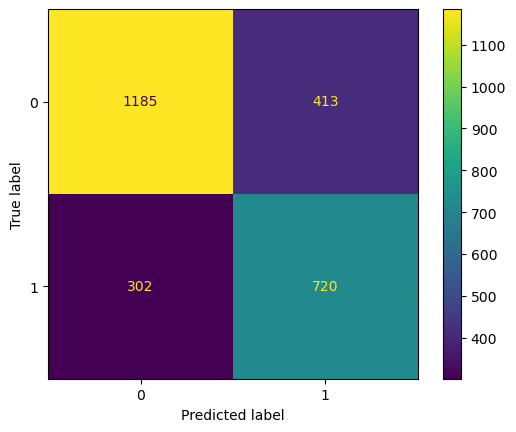

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1598
           1       0.64      0.70      0.67      1022

    accuracy                           0.73      2620
   macro avg       0.72      0.72      0.72      2620
weighted avg       0.73      0.73      0.73      2620


SVC Test


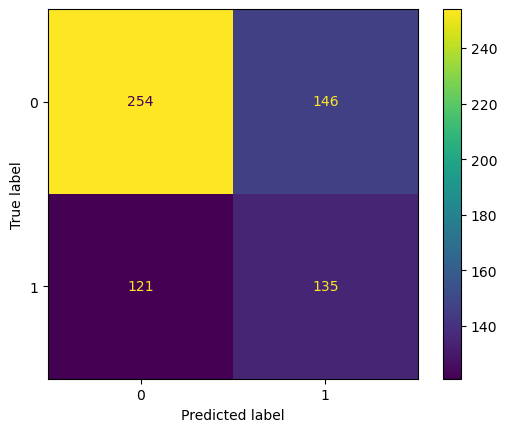

              precision    recall  f1-score   support

           0       0.68      0.64      0.66       400
           1       0.48      0.53      0.50       256

    accuracy                           0.59       656
   macro avg       0.58      0.58      0.58       656
weighted avg       0.60      0.59      0.60       656



In [104]:
# calling function for SVC
print('SVC Train')
performance_check(svc_pipe, X_train_capped, y_train)
print('')

print('SVC Test')
performance_check(svc_pipe, X_test_capped, y_test)

KNN Train


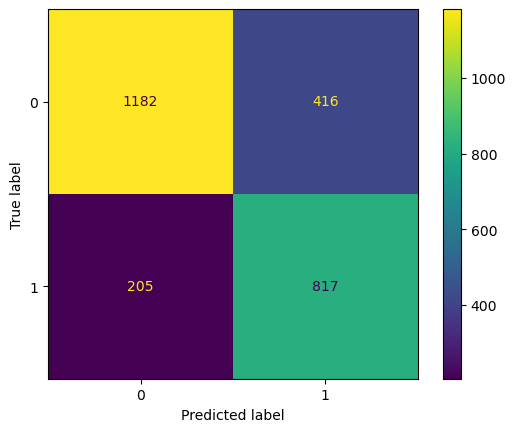

              precision    recall  f1-score   support

           0       0.85      0.74      0.79      1598
           1       0.66      0.80      0.72      1022

    accuracy                           0.76      2620
   macro avg       0.76      0.77      0.76      2620
weighted avg       0.78      0.76      0.77      2620


KNN Test


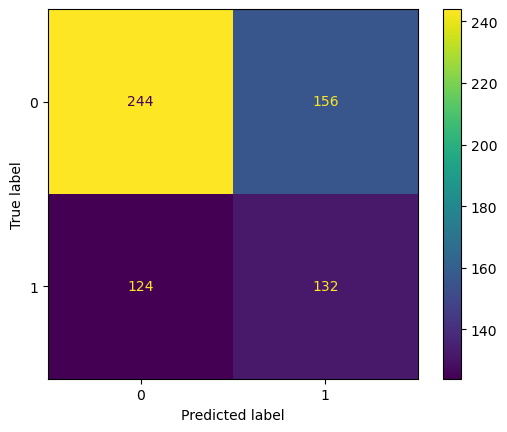

              precision    recall  f1-score   support

           0       0.66      0.61      0.64       400
           1       0.46      0.52      0.49       256

    accuracy                           0.57       656
   macro avg       0.56      0.56      0.56       656
weighted avg       0.58      0.57      0.58       656



In [105]:
# calling function for KNN
print('KNN Train')
performance_check(knn_pipe, X_train_capped, y_train)
print('')

print('KNN Test')
performance_check(knn_pipe, X_test_capped, y_test)

Tree Train


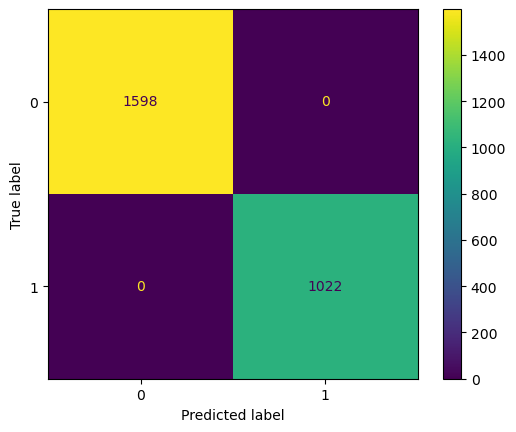

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1598
           1       1.00      1.00      1.00      1022

    accuracy                           1.00      2620
   macro avg       1.00      1.00      1.00      2620
weighted avg       1.00      1.00      1.00      2620


Tree Test


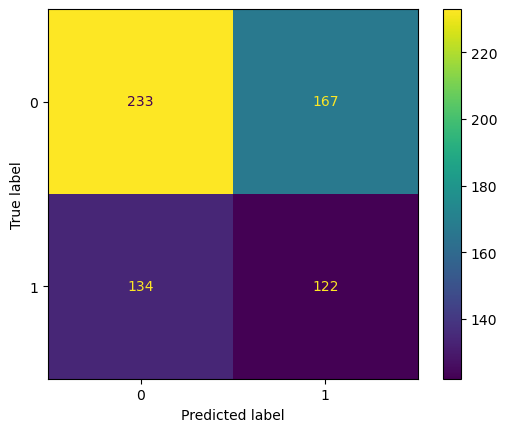

              precision    recall  f1-score   support

           0       0.63      0.58      0.61       400
           1       0.42      0.48      0.45       256

    accuracy                           0.54       656
   macro avg       0.53      0.53      0.53       656
weighted avg       0.55      0.54      0.55       656



In [106]:
# calling function for DecisionTree
print('Tree Train')
performance_check(tree_pipe, X_train_capped, y_train)
print('')

print('Tree Test')
performance_check(tree_pipe, X_test_capped, y_test)

AdaBoost Train


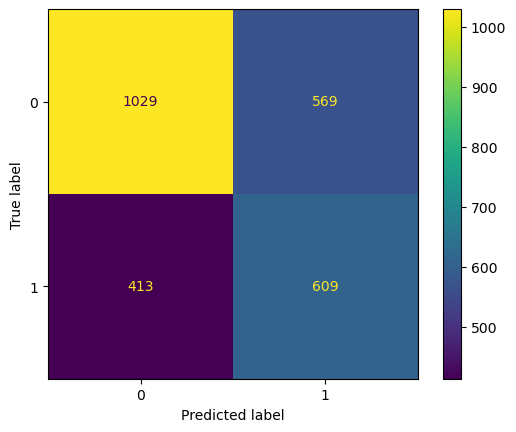

              precision    recall  f1-score   support

           0       0.71      0.64      0.68      1598
           1       0.52      0.60      0.55      1022

    accuracy                           0.63      2620
   macro avg       0.62      0.62      0.62      2620
weighted avg       0.64      0.63      0.63      2620


AdaBoost Test


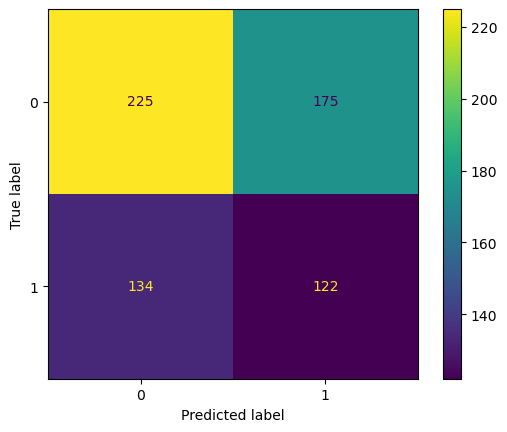

              precision    recall  f1-score   support

           0       0.63      0.56      0.59       400
           1       0.41      0.48      0.44       256

    accuracy                           0.53       656
   macro avg       0.52      0.52      0.52       656
weighted avg       0.54      0.53      0.53       656



In [15]:
# calling function for AdaBoost
print('AdaBoost Train')
performance_check(ada_pipe, X_train_capped, y_train)
print('')

print('AdaBoost Test')
performance_check(ada_pipe, X_test_capped, y_test)

**Recall Metric**
- Recall measures out of all the actual positive cases, how many were successfully identified by the model. This is the metric that will be used for the dataset since, classifying non-drinkable water as drinkable is more dangerous.

## Cross-Validation

In [21]:
# random forest cross-validation
forest_scores = cross_val_score(forest_pipe, X_train_capped, y_train, cv=10, scoring='recall')
print(f"Random Forest CV Recall: {np.mean(forest_scores):.3f} +/- {np.std(forest_scores):.3f}")

# SVC cross-validation
svc_scores = cross_val_score(svc_pipe, X_train_capped, y_train, cv=10, scoring='recall')
print(f"SVC CV Recall: {np.mean(svc_scores):.3f} +/- {np.std(svc_scores):.3f}")

# KNN cross-validation
knn_scores = cross_val_score(knn_pipe, X_train_capped, y_train, cv=10, scoring='recall')
print(f"KNN CV Recall: {np.mean(knn_scores):.3f} +/- {np.std(knn_scores):.3f}")

# decision tree cross-validation
tree_scores = cross_val_score(tree_pipe, X_train_capped, y_train, cv=10, scoring='recall')
print(f"Decision Tree CV Recall: {np.mean(tree_scores):.3f} +/- {np.std(tree_scores):.3f}")

# adaboost cross-validation
ada_scores = cross_val_score(ada_pipe, X_train_capped, y_train, cv=10, scoring='recall')
print(f"AdaBoost CV Recall: {np.mean(ada_scores):.3f} +/- {np.std(ada_scores):.3f}")

Random Forest CV Recall: 0.444 +/- 0.047
SVC CV Recall: 0.560 +/- 0.061
KNN CV Recall: 0.551 +/- 0.063
Decision Tree CV Recall: 0.507 +/- 0.045
AdaBoost CV Recall: 0.485 +/- 0.048


- RandomForest has the best result but imbalanced towards class 0 and will try hyperparameter tuning it.
- KNN is worth looking since it's not computationally expensive
- SVC which is the most expensive one will be the last resort since it's quite expensive.
- Decision Tree won't be continued since RandomForest is a bagging model of decision tree

## Hyperparameter Tuning

### Random Forest

In [15]:
# gridsearch for Random Forest
param_forest = {
    'randomforestclassifier__n_estimators': [10, 25, 50, 75, 100],
    'randomforestclassifier__max_depth': [10, 20, 30, 40, 50],       
    'randomforestclassifier__min_samples_split': [2, 5],     
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],       
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
    'randomforestclassifier__criterion': ["gini", "entropy", "log_loss"]
}

# forest
grid_forest = GridSearchCV(estimator=forest_pipe, param_grid=param_forest, 
                           n_jobs=-1, cv=5, scoring='recall', verbose=1) 

start_time = time.time()
grid_forest.fit(X_train_capped, y_train)
end_time = time.time()

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


In [109]:
print('Best parameters found:\n', grid_forest.best_params_)
best_forest = grid_forest.best_estimator_

Best parameters found:
 {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 10}


Best Random Forest Train


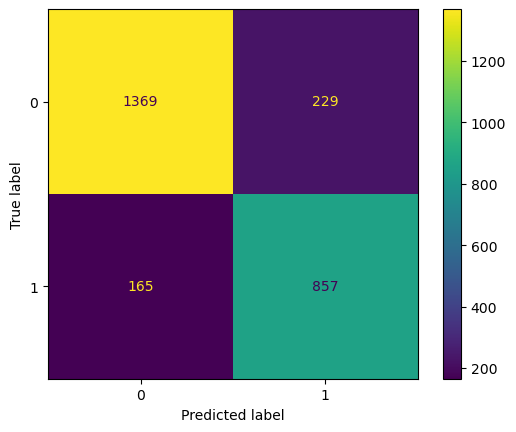

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1598
           1       0.79      0.84      0.81      1022

    accuracy                           0.85      2620
   macro avg       0.84      0.85      0.84      2620
weighted avg       0.85      0.85      0.85      2620


Best Random Forest Test


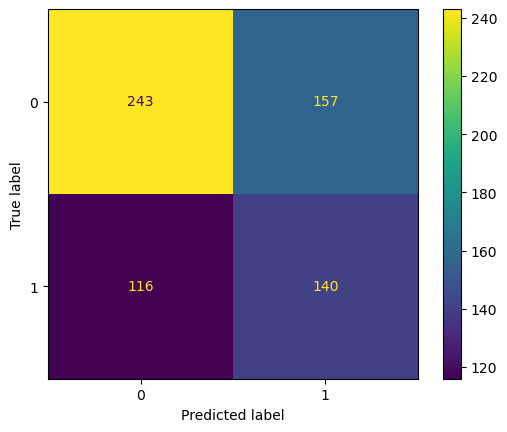

              precision    recall  f1-score   support

           0       0.68      0.61      0.64       400
           1       0.47      0.55      0.51       256

    accuracy                           0.58       656
   macro avg       0.57      0.58      0.57       656
weighted avg       0.60      0.58      0.59       656



In [110]:
# calling function for forest
print('Best Random Forest Train')
performance_check(best_forest, X_train_capped, y_train)
print('')

print('Best Random Forest Test')
performance_check(best_forest, X_test_capped, y_test)

In [111]:
# forest validation
best_forest_scores = cross_val_score(best_forest, X_train_capped, y_train, cv=10, scoring='recall')
print(f"Best Random Forest CV Recall: {np.mean(best_forest_scores):.3f} +/- {np.std(best_forest_scores):.3f}")

Best Random Forest CV Recall: 0.505 +/- 0.039


- Considered: Overfit

### KNN

In [112]:
# gridsearch for KNN
param_grid = {
    'kneighborsclassifier__n_neighbors': [3,4, 5, 6, 7, 8, 9],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan']
}
# knn
grid_knn = GridSearchCV(estimator=knn_pipe, param_grid=param_grid, 
                           n_jobs=-1, cv=5, scoring='recall', verbose=3) 

start_time = time.time()
grid_knn.fit(X_train_capped, y_train)
end_time = time.time()

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 2/5] END randomforestclassifier__criterion=log_loss, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=25;, score=0.490 total time=   0.6s
[CV 2/5] END randomforestclassifier__criterion=log_loss, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=75;, score=0.446 total time=   1.7s
[CV 3/5] END randomforestclassifier__criterion=log_loss, randomforestclassifier__max_depth=40, randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=4, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=200;, score=0.461 total time=   3.0s
[CV 2/5] END randomforestclassifier__

In [113]:
print('Best parameters found:\n', grid_knn.best_params_)
best_knn = grid_knn.best_estimator_

Best parameters found:
 {'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__weights': 'distance'}


Best KNN Train


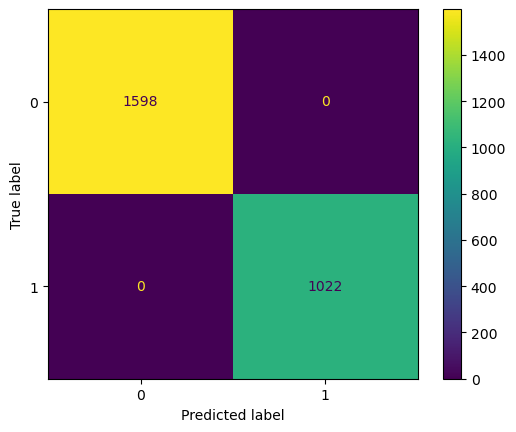

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1598
           1       1.00      1.00      1.00      1022

    accuracy                           1.00      2620
   macro avg       1.00      1.00      1.00      2620
weighted avg       1.00      1.00      1.00      2620


Best KNN Test


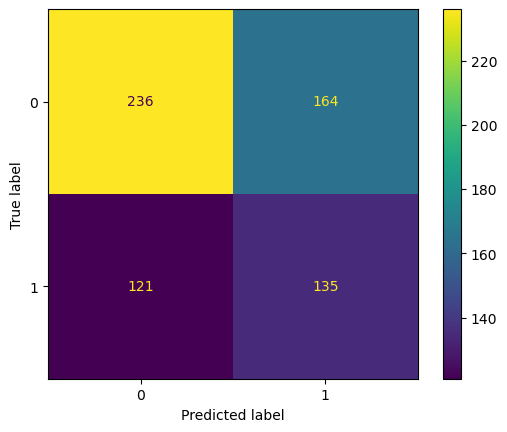

              precision    recall  f1-score   support

           0       0.66      0.59      0.62       400
           1       0.45      0.53      0.49       256

    accuracy                           0.57       656
   macro avg       0.56      0.56      0.56       656
weighted avg       0.58      0.57      0.57       656



In [114]:
# calling function for KNN
print('Best KNN Train')
performance_check(best_knn, X_train_capped, y_train)
print('')

print('Best KNN Test')
performance_check(best_knn, X_test_capped, y_test)

In [115]:
# knn validation
best_knn_scores = cross_val_score(best_knn, X_train_capped, y_train, cv=10, scoring='recall')
print(f"Best KNN CV Recall: {np.mean(best_knn_scores):.3f} +/- {np.std(best_knn_scores):.3f}")

Best KNN CV Recall: 0.581 +/- 0.059


- KNN overfits

### SVC

In [16]:
# gridsearch for SVC
param_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['rbf', 'poly', 'sigmoid'],
    'svc__gamma': ['scale','auto', 1, 0.1],
    'svc__class_weight': [None, 'balanced']
}

grid_svc = GridSearchCV(svc_pipe, param_grid=param_svc, cv=5, scoring='recall', verbose=1)

start_time = time.time()
grid_svc.fit(X_train_capped, y_train)
end_time = time.time()

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [117]:
print('Best parameters found:\n', grid_svc.best_params_)
best_svc = grid_svc.best_estimator_

Best parameters found:
 {'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


Best SVC Train


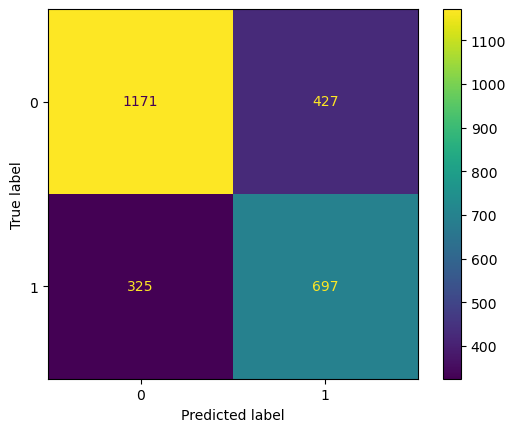

              precision    recall  f1-score   support

           0       0.78      0.73      0.76      1598
           1       0.62      0.68      0.65      1022

    accuracy                           0.71      2620
   macro avg       0.70      0.71      0.70      2620
weighted avg       0.72      0.71      0.72      2620


Best SVC Test


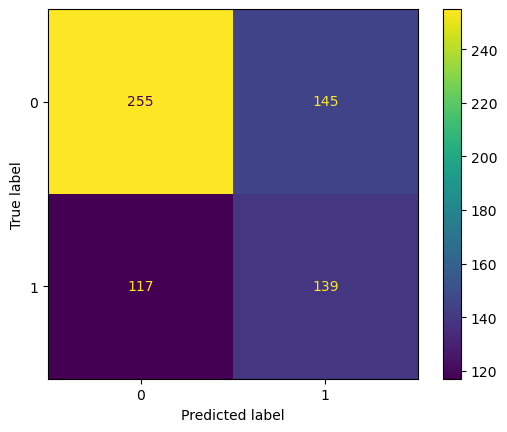

              precision    recall  f1-score   support

           0       0.69      0.64      0.66       400
           1       0.49      0.54      0.51       256

    accuracy                           0.60       656
   macro avg       0.59      0.59      0.59       656
weighted avg       0.61      0.60      0.60       656



In [122]:
# calling function for svc
print('Best SVC Train')
performance_check(best_svc, X_train_capped, y_train)
print('')

print('Best SVC Test')
performance_check(best_svc, X_test_capped, y_test)

In [119]:
# svc validation
best_svc_scores = cross_val_score(best_svc, X_train_capped, y_train, cv=10, scoring='recall')
print(f" Best SVC CV Recall: {np.mean(best_svc_scores):.3f} +/- {np.std(best_svc_scores):.3f}")

 Best SVC CV Recall: 0.550 +/- 0.056


- Really good results but still overfit

### AdaBoost

In [22]:
# hyperparameter tuning ada
param_ada = {
    'adaboostclassifier__n_estimators': [10, 25, 50, 100, 200],
    'adaboostclassifier__learning_rate': [0.5, 0.75, 1],
    "adaboostclassifier__algorithm": ["SAMME", "SAMME.R"]
}

# adaboost grid search
grid_ada = GridSearchCV(ada_pipe, param_grid=param_ada, cv=5, scoring='recall', verbose=1, n_jobs=-1)

grid_ada.fit(X_train_capped, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['ph',
                                                                          'hardness',
                                                                          'solids',
                                                                          'chloramines',
                                                                          'sulfate',
                                                                          'conductivity',
                                                                          'organic_carbon',
                                                                          'trihalomethanes',
                                                                          'turbidity'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('adaboostclassifier',
                                        AdaBoostClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'adaboostclassifier__algorithm': ['SAMME', 'SAMME.R'],
                         'adaboostclassifier__learning_rate': [0.5, 0.75, 1],
                         'adaboostclassifier__n_estimators': [10, 25, 50, 100,
                                                              200]},
             scoring='recall', verbose=1)

In [121]:
# ada result
best_parameters = grid_ada.best_params_
print(f"Best AdaBoost parameters: {best_parameters}")

best_ada = grid_ada.best_estimator_

Best AdaBoost parameters: {'adaboostclassifier__algorithm': 'SAMME', 'adaboostclassifier__learning_rate': 0.75, 'adaboostclassifier__n_estimators': 50}


Best AdaBoost Train


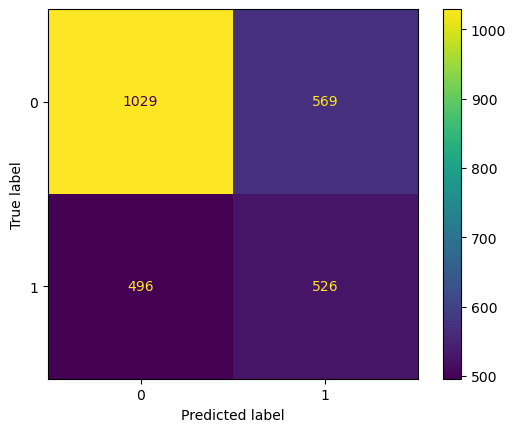

              precision    recall  f1-score   support

           0       0.67      0.64      0.66      1598
           1       0.48      0.51      0.50      1022

    accuracy                           0.59      2620
   macro avg       0.58      0.58      0.58      2620
weighted avg       0.60      0.59      0.60      2620


Best AdaBoost Test


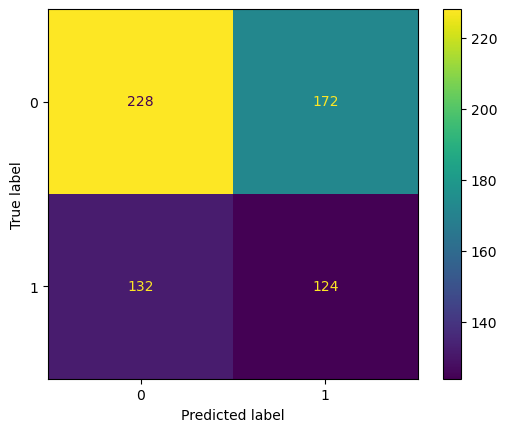

              precision    recall  f1-score   support

           0       0.63      0.57      0.60       400
           1       0.42      0.48      0.45       256

    accuracy                           0.54       656
   macro avg       0.53      0.53      0.52       656
weighted avg       0.55      0.54      0.54       656



In [123]:
# calling function for AdaBoost
print('Best AdaBoost Train')
performance_check(best_ada, X_train_capped, y_train)
print('')

print('Best AdaBoost Test')
performance_check(best_ada, X_test_capped, y_test)

In [129]:
# ada validation
best_ada_scores = cross_val_score(best_ada, X_train_capped, y_train, cv=10, scoring='recall')
print(f" Best SVC CV Recall: {np.mean(best_ada_scores):.3f} +/- {np.std(best_ada_scores):.3f}")

 Best SVC CV Recall: 0.494 +/- 0.075


- Adaboost, underfitted

### AdaBoost SVC

Best AdaBoost parameters: {'adaboostclassifier__algorithm': 'SAMME', 'adaboostclassifier__learning_rate': 0.75, 'adaboostclassifier__n_estimators': 50}

Best parameters found:
 {'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

In [126]:
# adaBoost svc Pipe
ada_svc_pipe = make_pipeline_imb(
    preprocessor,
    SMOTE(random_state=42),
    AdaBoostClassifier(
        SVC(
            C= 1, kernel='rbf',
            class_weight= None,
            gamma= 0.1,
            probability=True, random_state=42
        ),
        n_estimators=50,
        random_state=42,
        algorithm= 'SAMME',
        learning_rate= 0.75,
    ))

ada_svc_pipe.fit(X_train_capped, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['ph', 'hardness', 'solids',
                                                   'chloramines', 'sulfate',
                                                   'conductivity',
                                                   'organic_carbon',
                                                   'trihalomethanes',
                                                   'turbidity'])])),
                ('smote', SMOTE(random_state=42)),
                ('adaboostclassifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=SVC(C=1, gamma=0.1,
                                                  probability=True,
                                                  random_state=42),
                                    learning_rate=0.75, random_state=42))])

AdaBoost SVC Train


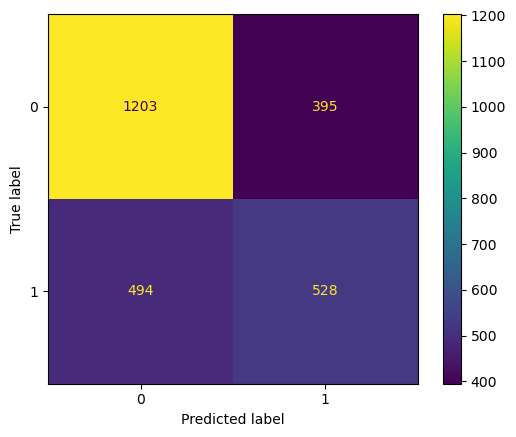

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1598
           1       0.57      0.52      0.54      1022

    accuracy                           0.66      2620
   macro avg       0.64      0.63      0.64      2620
weighted avg       0.66      0.66      0.66      2620


AdaBoost SVC Test


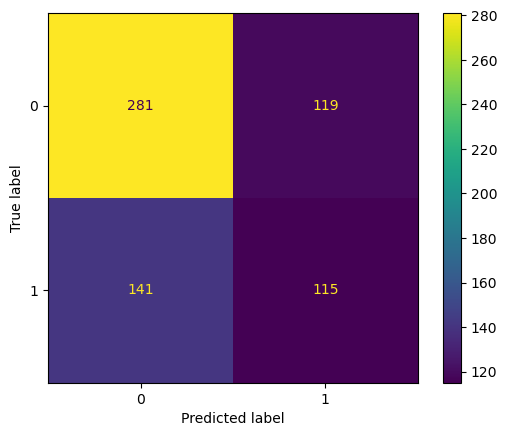

              precision    recall  f1-score   support

           0       0.67      0.70      0.68       400
           1       0.49      0.45      0.47       256

    accuracy                           0.60       656
   macro avg       0.58      0.58      0.58       656
weighted avg       0.60      0.60      0.60       656



In [127]:
# calling function for AdaBoost SVC
print('AdaBoost SVC Train')
performance_check(ada_svc_pipe, X_train_capped, y_train)
print('')

print('AdaBoost SVC Test')
performance_check(ada_svc_pipe, X_test_capped, y_test)

In [154]:
# ada svc validation
best_ada_svc_scores = cross_val_score(ada_svc_pipe, X_train_capped, y_train, cv=5, scoring='recall')
print(f" Best Ada SVC CV Recall: {np.mean(best_ada_svc_scores):.3f} +/- {np.std(best_ada_svc_scores):.3f}")

 Best Ada SVC CV Recall: 0.583 +/- 0.068


- Adaboost SVC is considered goodfit but imbalance to class 0

### More Precise Random Forest

Best parameters found:
 {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 10}

In [136]:
# gridsearch for Random Forest
param_forest_2 = {
    'randomforestclassifier__n_estimators': [10, 20, 30],
    'randomforestclassifier__max_depth': [2, 4, 6, 8, 10],       
    'randomforestclassifier__min_samples_split': [2, 6, 8, 10],     
    'randomforestclassifier__min_samples_leaf': [2, 6, 8, 10],       
    'randomforestclassifier__max_features': [1, 2, 4, 9,'sqrt'],
    'randomforestclassifier__criterion': ["gini"]
}

# forest
grid_forest_2 = GridSearchCV(estimator=forest_pipe, param_grid=param_forest_2, 
                           n_jobs=-1, cv=5, scoring='recall', verbose=1) 

start_time = time.time()
grid_forest_2.fit(X_train_capped, y_train)
end_time = time.time()

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


In [139]:
# forest 2
best_parameters = grid_forest_2.best_params_
print(f"Best Random Forest 2 parameters: {best_parameters}")

best_forest_2 = grid_forest_2.best_estimator_

Best Random Forest 2 parameters: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 2, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 6, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 10}


Random Forest 2 Train


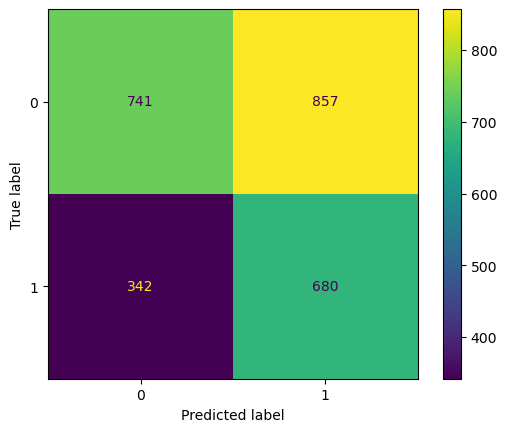

              precision    recall  f1-score   support

           0       0.68      0.46      0.55      1598
           1       0.44      0.67      0.53      1022

    accuracy                           0.54      2620
   macro avg       0.56      0.56      0.54      2620
weighted avg       0.59      0.54      0.54      2620


Random Forest 2 Test


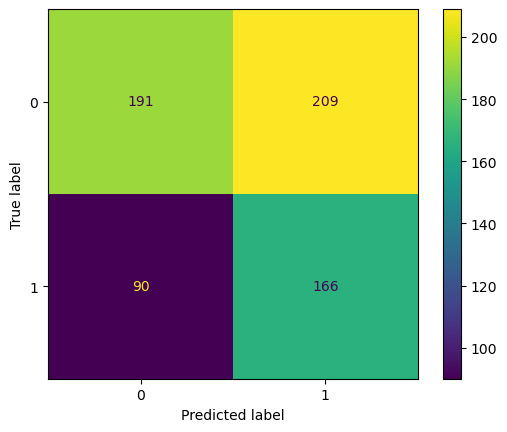

              precision    recall  f1-score   support

           0       0.68      0.48      0.56       400
           1       0.44      0.65      0.53       256

    accuracy                           0.54       656
   macro avg       0.56      0.56      0.54       656
weighted avg       0.59      0.54      0.55       656



In [140]:
# calling function for Random Forest 2
print('Random Forest 2 Train')
performance_check(best_forest_2, X_train_capped, y_train)
print('')

print('Random Forest 2 Test')
performance_check(best_forest_2, X_test_capped, y_test)

Best Random Forest 2 parameters: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 2, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 6, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 10}

In [147]:
# gridsearch for Random Forest
param_forest_3 = {
    'randomforestclassifier__n_estimators': [4, 6 , 8, 10],
    'randomforestclassifier__max_depth': [2, 4, 8],       
    'randomforestclassifier__min_samples_split': [0.5, 2, 3],     
    'randomforestclassifier__min_samples_leaf': [ 3, 4, 5, 6],       
    'randomforestclassifier__max_features': ['sqrt'],
    'randomforestclassifier__criterion': ["gini", 'entropy', 'log_loss']
}

# forest
grid_forest_3 = GridSearchCV(estimator=forest_pipe, param_grid=param_forest_3, 
                           n_jobs=-1, cv=5, scoring='recall', verbose=1) 

start_time = time.time()
grid_forest_3.fit(X_train_capped, y_train)
end_time = time.time()

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [149]:
# forest 3
best_parameters = grid_forest_3.best_params_
print(f"Best Random Forest 3 parameters: {best_parameters}")

best_forest_3 = grid_forest_3.best_estimator_

Best Random Forest 3 parameters: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 2, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 10}


Random Forest 3 Train


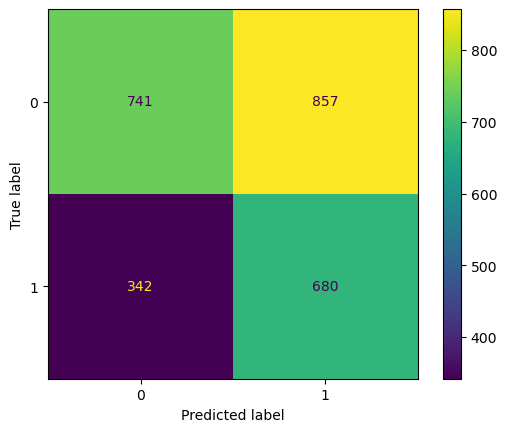

              precision    recall  f1-score   support

           0       0.68      0.46      0.55      1598
           1       0.44      0.67      0.53      1022

    accuracy                           0.54      2620
   macro avg       0.56      0.56      0.54      2620
weighted avg       0.59      0.54      0.54      2620


Random Forest 3 Test


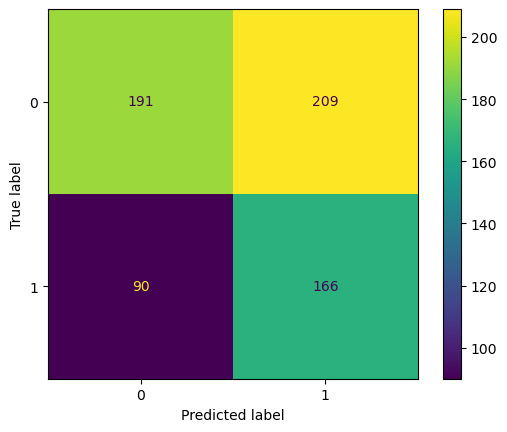

              precision    recall  f1-score   support

           0       0.68      0.48      0.56       400
           1       0.44      0.65      0.53       256

    accuracy                           0.54       656
   macro avg       0.56      0.56      0.54       656
weighted avg       0.59      0.54      0.55       656



In [150]:
# calling function for Random Forest 3
print('Random Forest 3 Train')
performance_check(best_forest_3, X_train_capped, y_train)
print('')

print('Random Forest 3 Test')
performance_check(best_forest_3, X_test_capped, y_test)

In [152]:
# forest 3 validation
best_forest_3_scores = cross_val_score(best_forest_3, X_train_capped, y_train, cv=20, scoring='recall')
print(f" Best Forest 3 CV Recall: {np.mean(best_forest_3_scores):.3f} +/- {np.std(best_forest_3_scores):.3f}")

 Best Forest 3 CV Recall: 0.538 +/- 0.098


- Both class 0 underfit and class 1 good fit. The most stable and best overall so far hence will be using this for deployment.
- Random Forest have the best overall score could be due to able to handle non-linear data effectively and less likely to overfitting.
- SVC is a good alternative and should be explored further but computationally expensive (takes a while to run), it's effective for high dimensions features like this and robust
- KNN is simple and adaptive but with curse of dimensionality, high dimensional data degrades it's performance
- DecisionTree alone is prone to overfit but easy to understand. It also effective on handling non-linear data

# 9. Model Saving

In [153]:
# saving the model
dump(best_forest_3, 'best_model.pkl')

['best_model.pkl']

# 10. Conclusion

The dataset is well documented but has missing values. These missing values after exploration deemed MCAR and most likely due to the person in charge taking the water samples did not have the equipment to messure these missing values chemical levels. All the chemicals don't have a relationship with each other or a trend, and each of them are important because the PCA shows a linear relationship between number of features and the percentage of data kept. Most water sample has a ph of 5-9, has a quite high amount of chemicals like sulfate, chloramines and trihalomethanes which doesn't seem to have difference between the ones potable and non-potable. It can be assumed that the water samples are from environment that is scarce on really good drinkable water or a highly contaminated environment like a factory side of the city. The model that gives the best overall score is RandomForest which has a recall of 65% meaning, when predicting if the water is drinkable or not, it will be correct 65% of the time. There are few things to suggest for the future. The SVC model can be further searched if resources are available, there needed to be more potable water data since the data is imbalanced towards non-potable water and dataset potability validity needed to be checked by the author.